# Project Loading Example

_This notebook uses a dataset of videos stored as a tensor flow datasets._

## Setup

## Import tfds and other libraries

In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

# For some reason we seem to need to load tf onto the GPU first
dummy = tf.constant( 32 )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

The dataset is packaged as a Tensorflow dataset in three sub categories.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
tfds.disable_progress_bar()
PROJECT_ROOT_DIR = "/content/drive/My Drive/computer_vision2/project"
print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')

os.makedirs(data_path, exist_ok = True)

print("Using directory: ", data_path)


/content/gdrive/My Drive/computer_vision2/project
Using directory:  /content/gdrive/My Drive/computer_vision2/project/tensorflow_data


In [5]:
def load_all_videos(dataset):
    iter_data = iter(dataset)
    all_videos = []
    try:
        while True:
            video = next(iter_data)
            all_videos.append(video)
    except StopIteration:
        pass
    return all_videos

flow_data_set1 = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)
flow_data_set2 = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set3 = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)

all_videos1 = load_all_videos(flow_data_set1['train'])
all_videos2 = load_all_videos(flow_data_set2['train'])
all_videos3 = load_all_videos(flow_data_set3['train'])


In [6]:
len(all_videos1) #The number of videos in the first set

30

In [7]:
len(all_videos2) #The number of videos in the second set

30

In [8]:
len(all_videos3) #The number of videos in the third set

30

Function **load_all_videos** that takes a dataset as input and iterates through its elements, collecting all videos into a list, which is then returned. Subsequently, we applly this function to three different TensorFlow Datasets (flow_data_set1, flow_data_set2, and flow_data_set3), extracting and storing all training videos from each dataset into separate lists (all_videos1, all_videos2, and all_videos3) each list has equally 30 videos.








# import libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# from flow_util import *

# Defining a Function to Find the Index of a Specific Element in a List

In [10]:
def find_index(input, id):
    for i in range(len(input)):
        if input[i] == id:
            return i
            break

### Processing First Set of Videos and Storing Frame and

In [11]:
# Access the first dictionary in the list
first_video_data = all_videos1[0]

# Print the keys
print(first_video_data.keys())

dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video'])


The key that is likely to be most relevant for single-category object detection in the provided dataset is likely to be 'instances'. This key often contains information related to object instances, including bounding boxes, labels, and potentially other relevant information for object detection tasks.

In [12]:
# Retrieving and Displaying the Keys of the 'Instances' Dictionary in the First Video Data
first_video_data['instances'].keys()

dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3d', 'category', 'friction', 'image_positions', 'mass', 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility'])

In the resulted set of keys for instances, several keys are relevant for single-category object detection:

**'category':** This key contains information about the category or label of each instance, providing the class information needed for single-category object detection.

**'bboxes':** This key is essential as it contains the bounding box coordinates for each instance in the image, crucial for localizing and delineating the objects.

**'image_positions':** This key contain information about the positions of instances within the image, offering additional spatial context that could be useful for detection.

**'visibility':** This key indicate the visibility or occlusion status of instances, aiding in handling partially visible or occluded objects during the detection process.

*To perform single-category object detection, we would primarily focus on utilizing information from the **'category'** and **'bboxes'** keys for labeling and localization purposes.*

# Defining a Function to Visualize Images with their Corresponding Bounding Boxes and Categories

In [13]:
# Define the category mapping
category_mapping = {
    0: 'Action Figures',
    1: 'Bag',
    2: 'Board Games',
    3: 'Bottles and Cans and Cups',
    4: 'Camera',
    5: 'Car Seat',
    6: 'Consumer Goods',
    7: 'Hat',
    8: 'Headphones',
    9: 'Keyboard',
    10: 'Legos',
    11: 'Media Cases',
    12: 'Mouse',
    13: 'None',
    14: 'Shoe',
    15: 'Stuffed Toys',
    16: 'Toys',
    17: 'Blocker',
}


We define a dictionary category_mapping that maps numerical category labels to corresponding human-readable category names, facilitating the interpretation of object categories.

#### Defining Functions for Normalizing, Resizing and Applying Gaussian Blur to Images

In [14]:
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage import filters

def normalize_image(image):
    return image / 255.0

def resize_image(image, size=(640,640)):
    return resize(image, size, mode='reflect')

def apply_gaussian_blur(image, sigma=1):
    return filters.gaussian(image, sigma=sigma)

We define three image processing functions: normalize_image scales pixel values to the range [0, 1],
resize_image resizes an image to a specified size using reflective mode interpolation,
and apply_gaussian_blur applies Gaussian blur to the image using a specified standard deviation (sigma), providing a set of pre-processing operations often employed in computer vision tasks and affecting the outcome results.

### Applying Image Processing Techniques During Video Frame Extraction

In [15]:
import pandas as pd

def process_videos_with_filter(all_videos):
    # Initialize lists to store the images, bounding boxes, resolutions, image ids and bounding box ids
    images_list = []
    bboxes_list = []
    resolutions_list = []
    bbox_ids_list = []

    image_id = 0
    bbox_id = 0

    for train_data in all_videos:
        num_frames = int(train_data['metadata']['num_frames'])
        resolution = [int(train_data['metadata']['height'].numpy()), int(train_data['metadata']['width'].numpy())]

        for i in range(num_frames):
            # Append the image to the list
            image = train_data['video'][i, :, :, :].numpy()
            # Normalize, resize and apply filter to the image before appending
            image = normalize_image(image)
            image = resize_image(image)
            image = apply_gaussian_blur(image)
            images_list.append(image)

            # Append the resolution to the list
            resolutions_list.append(resolution)

            # Initialize list to store the bounding boxes for this frame
            frame_bboxes = []

            for id in range(train_data['instances']['bbox_frames'].shape[0]):
                if i in train_data['instances']['bbox_frames'][id]:
                    t = find_index(train_data['instances']['bbox_frames'][id], i)
                    item = train_data['instances']['bboxes'][id, t, :]

                    # Calculate normalized bounding box coordinates
                    y_min = int(item[0] * float(resolution[0]))
                    x_min = int(item[1] * float(resolution[1]))
                    y_max = int(item[2] * float(resolution[0]))
                    x_max = int(item[3] * float(resolution[1]))

                    # Normalize the bounding box coordinates
                    y_min_normalized = y_min / float(resolution[0])
                    x_min_normalized = x_min / float(resolution[1])
                    y_max_normalized = y_max / float(resolution[0])
                    x_max_normalized = x_max / float(resolution[1])

                    # Get the category (label) for this bounding box
                    category = train_data['instances']['category'][id].numpy()

                    # Append the normalized bounding box and its category to the list
                    frame_bboxes.append([bbox_id, x_min_normalized, y_min_normalized, x_max_normalized, y_max_normalized, category])

                    bbox_id += 1

            # Append the list of bounding boxes for this frame to the main list
            bboxes_list.append(frame_bboxes)

    # Convert the lists to a DataFrame
    df = pd.DataFrame({
        'image': images_list,
        'resolution': resolutions_list,
        'bounding_boxes': bboxes_list
    })

    return df



we define **process_videos_with_filter** function that takes a list of video datasets, iterates through frames, normalizes, resizes, and applies a Gaussian blur to each frame's image. It extracts relevant information such as bounding boxes, resolutions, and their corresponding categories from the instances in the videos and constructs a Pandas DataFrame to organize and structure this data, which can be further utilized for training and analyzing models in computer vision tasks like object detection. Additionally, also we  handle the normalization and conversion of bounding box coordinates to be used in our task.

#### Processing First Set of Videos with Image Filters and Storing Frame, Resolution, and Bounding Box Data in a DataFrame

In [16]:
df1_frames_filter = process_videos_with_filter(all_videos1)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


#### Viewing Filter-Applied Video Data for first Dataframe

In [17]:
df1_frames_filter

,image,resolution,bounding_boxes
0,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[0, 0.40234375, 0.2890625, 0.6953125, 0.50390..."
1,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[6, 0.40625, 0.296875, 0.6953125, 0.5, 13], [..."
2,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[12, 0.40625, 0.30078125, 0.69921875, 0.50390..."
3,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[19, 0.40625, 0.30859375, 0.703125, 0.5039062..."
4,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[26, 0.40234375, 0.32421875, 0.7109375, 0.503..."
...,...,...,...
715,"[[[0.7671606616239601, 0.3160184569375165, 0.1...","[256, 256]","[[2410, 0.48828125, 0.2578125, 0.71875, 0.5820..."
716,"[[[0.7671606616239601, 0.31813608291581275, 0....","[256, 256]","[[2411, 0.48828125, 0.2578125, 0.71875, 0.5742..."
717,"[[[0.7671606616239601, 0.31813608291581275, 0....","[256, 256]","[[2412, 0.4921875, 0.26171875, 0.71484375, 0.5..."
718,"[[[0.7671606616239601, 0.31813608291581275, 0....","[256, 256]","[[2413, 0.48828125, 0.26953125, 0.72265625, 0...."


#### Processing second Set of Videos with Image Filters and Storing Frame, Resolution, and Bounding Box Data in a DataFrame

In [18]:
df2_frames_filter = process_videos_with_filter(all_videos2)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


#### Viewing Filter-Applied Video Data for second Dataframe

In [19]:
df2_frames_filter

,image,resolution,bounding_boxes
0,"[[[0.3775486248256695, 0.34253058183186536, 0....","[256, 256]","[[0, 0.14453125, 0.41015625, 0.6796875, 0.9960..."
1,"[[[0.381745670524287, 0.3492954833065768, 0.37...","[256, 256]","[[7, 0.140625, 0.421875, 0.6484375, 0.9765625,..."
2,"[[[0.3791012125943267, 0.34512287468789415, 0....","[256, 256]","[[14, 0.14453125, 0.4296875, 0.609375, 0.95703..."
3,"[[[0.37462843932816436, 0.33933460434864215, 0...","[256, 256]","[[21, 0.1640625, 0.4375, 0.58984375, 0.9414062..."
4,"[[[0.38098015074825287, 0.3456861905426663, 0....","[256, 256]","[[28, 0.19140625, 0.4375, 0.62109375, 0.960937..."
...,...,...,...
715,"[[[0.5555128393522968, 0.6040339830943366, 0.2...","[256, 256]","[[2497, 0.2890625, 0.12890625, 0.51953125, 0.3..."
716,"[[[0.5631258492641458, 0.5938969249035853, 0.2...","[256, 256]","[[2503, 0.29296875, 0.125, 0.50390625, 0.34375..."
717,"[[[0.5681313384116007, 0.5587135413950546, 0.4...","[256, 256]","[[2509, 0.296875, 0.12109375, 0.4921875, 0.339..."
718,"[[[0.5482282017416176, 0.5089176331030555, 0.4...","[256, 256]","[[2515, 0.265625, 0.1171875, 0.484375, 0.33984..."


#### Processing third  Set of Videos with Image Filters and Storing Frame, Resolution, and Bounding Box Data in a DataFrame

In [20]:
df3_frames_filter = process_videos_with_filter(all_videos3)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


#### Viewing Filter-Applied Video Data for third Dataframe

In [21]:
df3_frames_filter

,image,resolution,bounding_boxes
0,"[[[0.8277266566594599, 0.7571383796233208, 0.5...","[256, 256]","[[0, 0.3359375, 0.1796875, 0.63671875, 0.39453..."
1,"[[[0.8159619090350856, 0.7375306939275381, 0.4...","[256, 256]","[[7, 0.33203125, 0.1796875, 0.65234375, 0.3984..."
2,"[[[0.8502159971536075, 0.7825094261971112, 0.5...","[256, 256]","[[14, 0.33203125, 0.1796875, 0.66796875, 0.402..."
3,"[[[0.8776672184839224, 0.8238049305842152, 0.6...","[256, 256]","[[21, 0.3359375, 0.18359375, 0.6875, 0.40625, ..."
4,"[[[0.8776673759253946, 0.8238050462899875, 0.6...","[256, 256]","[[28, 0.34765625, 0.203125, 0.69921875, 0.4179..."
...,...,...,...
715,"[[[0.6994299587162645, 0.28891826399159914, 0....","[256, 256]","[[2482, 0.33984375, 0.34375, 0.5703125, 0.5742..."
716,"[[[0.7594684087398353, 0.3388206613190722, 0.2...","[256, 256]","[[2485, 0.3671875, 0.34375, 0.5546875, 0.57031..."
717,"[[[0.7600201179057287, 0.3482552963239249, 0.1...","[256, 256]","[[2488, 0.3984375, 0.34765625, 0.53515625, 0.5..."
718,"[[[0.7396105955241753, 0.33149182375031316, 0....","[256, 256]","[[2491, 0.40234375, 0.34375, 0.55859375, 0.562..."


We compelted apply **process_videos_with_filter** function to out three sets of videos we have to make them suitable for further using in detection task

#### Concatenating Multiple DataFrames of Processed Frames, Resolutions, and Bounding Box Data with Applied Image Filters into a Single DataFrame

In [22]:
df_frames_filter = pd.concat([df1_frames_filter, df2_frames_filter, df3_frames_filter]).reset_index(drop=True)

#### Viewing Combined Filter-Applied Video Data



In [23]:
df_frames_filter

,image,resolution,bounding_boxes
0,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[0, 0.40234375, 0.2890625, 0.6953125, 0.50390..."
1,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[6, 0.40625, 0.296875, 0.6953125, 0.5, 13], [..."
2,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[12, 0.40625, 0.30078125, 0.69921875, 0.50390..."
3,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[19, 0.40625, 0.30859375, 0.703125, 0.5039062..."
4,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[26, 0.40234375, 0.32421875, 0.7109375, 0.503..."
...,...,...,...
2155,"[[[0.6994299587162645, 0.28891826399159914, 0....","[256, 256]","[[2482, 0.33984375, 0.34375, 0.5703125, 0.5742..."
2156,"[[[0.7594684087398353, 0.3388206613190722, 0.2...","[256, 256]","[[2485, 0.3671875, 0.34375, 0.5546875, 0.57031..."
2157,"[[[0.7600201179057287, 0.3482552963239249, 0.1...","[256, 256]","[[2488, 0.3984375, 0.34765625, 0.53515625, 0.5..."
2158,"[[[0.7396105955241753, 0.33149182375031316, 0....","[256, 256]","[[2491, 0.40234375, 0.34375, 0.55859375, 0.562..."


Here we have our concated dataframe that contain the processed videos from the original three datasets we have as we can see we have like 2160 row in our dataframe to deal with

### Defining a Function to Visualize Normalized Images with their Corresponding Bounding Boxes and Categories

In [24]:
def visualize_image_and_boxes_normalized(row, category_mapping):
    # Get image dimensions
    img_height, img_width = row['image'].shape[:2]

    # Visualize original image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(row['image'], cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Visualize image with bounding boxes
    axs[1].imshow(row['image'], cmap='gray')
    for box in row['bounding_boxes']:
        bbox_id, x_min, y_min, x_max, y_max, category = box

        # Scale normalized coordinates to image dimensions
        x_min *= img_width
        y_min *= img_height
        x_max *= img_width
        y_max *= img_height

        category_name = category_mapping.get(category, 'Unknown category')
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(x_min, y_min, f"{category_name}", color='white', fontsize=10, bbox=dict(facecolor='red', edgecolor='red', boxstyle='round,pad=0.5'))

    axs[1].set_title('Image with Bounding Boxes')
    axs[1].axis('off')

    plt.show()


### Visualizing the 251st Frame in the Filter-Applied DataFrame with its Associated Bounding Boxes and Categories

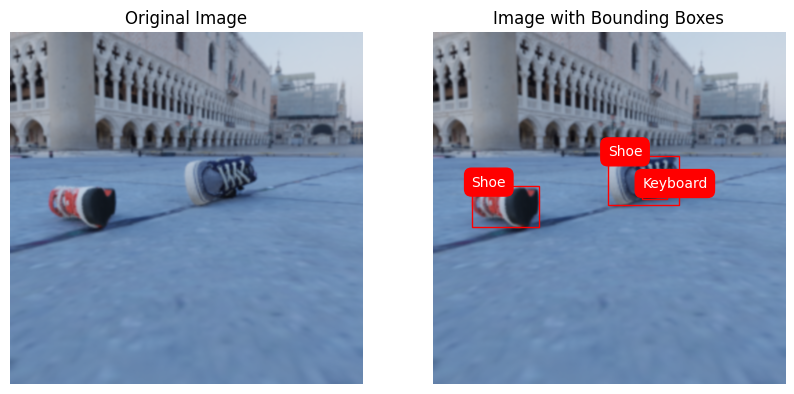

In [25]:
row = df1_frames_filter.iloc[250]
visualize_image_and_boxes_normalized(row, category_mapping)

Here we can see an example from our dataset as we have the original image and its corresponed bounding box around the instances exisit on it. we can see some images may have more than one item category in the same image and our task is singlr category object detection so we will choose one category that we would go further with it  

#Choosing category

In [28]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import io as skio
from skimage import img_as_ubyte

# Function to extract category 14 bounding boxes
def extract_category_14_bboxes(bboxes):
    return [bbox for bbox in bboxes if bbox[5] == 14]

# Filter the DataFrame for entries containing category 14 bounding boxes
df_frames_filter['category_14_bboxes'] = df_frames_filter['bounding_boxes'].apply(extract_category_14_bboxes)
df_category_14 = df_frames_filter[df_frames_filter['category_14_bboxes'].map(len) > 0]


In [29]:
row_with_index_1363 = df_category_14.loc[1363]
row_with_index_1363

image                 [[[0.7667858901034513, 0.6551783407686136, 0.4...
resolution                                                   [256, 256]
bounding_boxes        [[2027, 0.578125, 0.515625, 1.0, 1.0, 13], [20...
category_14_bboxes    [[2028, 0.23828125, 0.07421875, 0.421875, 0.30...
Name: 1363, dtype: object

In [30]:
df_category_14

,image,resolution,bounding_boxes,category_14_bboxes
0,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[0, 0.40234375, 0.2890625, 0.6953125, 0.50390...","[[4, 0.41796875, 0.4609375, 0.453125, 0.496093..."
1,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[6, 0.40625, 0.296875, 0.6953125, 0.5, 13], [...","[[10, 0.4375, 0.4609375, 0.4765625, 0.49609375..."
2,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[12, 0.40625, 0.30078125, 0.69921875, 0.50390...","[[17, 0.4453125, 0.4609375, 0.484375, 0.496093..."
3,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[19, 0.40625, 0.30859375, 0.703125, 0.5039062...","[[24, 0.4453125, 0.45703125, 0.48828125, 0.496..."
4,"[[[0.9341597419086096, 0.7838250580481643, 0.6...","[256, 256]","[[26, 0.40234375, 0.32421875, 0.7109375, 0.503...","[[31, 0.44140625, 0.453125, 0.48828125, 0.4960..."
...,...,...,...,...
2131,"[[[0.13807841604191734, 0.12893616667760263, 0...","[256, 256]","[[2394, 0.40234375, 0.4609375, 0.7734375, 0.82...","[[2398, 0.30859375, 0.4609375, 0.48828125, 0.5..."
2132,"[[[0.1864509439716011, 0.19256471323496943, 0....","[256, 256]","[[2401, 0.3359375, 0.47265625, 0.734375, 0.855...","[[2405, 0.296875, 0.4609375, 0.48046875, 0.558..."
2133,"[[[0.36472280347027386, 0.33299644331886735, 0...","[256, 256]","[[2408, 0.265625, 0.484375, 0.68359375, 0.8828...","[[2411, 0.28125, 0.4609375, 0.47265625, 0.5585..."
2134,"[[[0.36304608512016034, 0.39631973112812435, 0...","[256, 256]","[[2414, 0.19140625, 0.49609375, 0.62890625, 0....","[[2417, 0.26953125, 0.4609375, 0.46484375, 0.5..."


we have now our funal dataframe **df_category_14** that contain images that we will use for training and testing thes are the images that contain only one category which is ctegory 14 (shoe) and we also extracted the bounding boxes that are corresponded to category 14 in each image as may the image have more than one instance for the same category

#Training

 ### using the scikit-learn library to split dataset (df_category_14) into training, validation, and test sets. It then creates directories for storing images and labels in the YOLOv8 format, with functions to save the data appropriately.

In [31]:
from sklearn.model_selection import train_test_split
import os
from skimage import io as skio
from skimage.util import img_as_ubyte


# First, split the dataset into a training plus validation set and a test set
df_train_val, df_test = train_test_split(df_category_14, test_size=0.20)

# Now split the training plus validation set into individual training and validation sets
df_train, df_val = train_test_split(df_train_val, test_size=0.25)

# Define the base path for the dataset
base_path = "/content/Dataset2"

# Paths for images and labels inside train, valid, and test directories
train_images_path = os.path.join(base_path, "train", "images")
train_labels_path = os.path.join(base_path, "train", "labels")
val_images_path = os.path.join(base_path, "valid", "images")
val_labels_path = os.path.join(base_path, "valid", "labels")
test_images_path = os.path.join(base_path, "test", "images")
test_labels_path = os.path.join(base_path, "test", "labels")

# Create the necessary directories
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(train_labels_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True)
os.makedirs(test_labels_path, exist_ok=True)

# Function to save the image and labels in YOLOv8 format
def save_data(df, images_subpath, labels_subpath, data_type):
    for index, row in df.iterrows():
        # Convert image to uint8
        image_uint8 = img_as_ubyte(row['image'])

        # Save image
        img_filename = f"{data_type}_{index}.png"
        img_path = os.path.join(images_subpath, img_filename)
        skio.imsave(img_path, image_uint8)

        # Save label for category 4 bounding boxes
        label_filename = f"{data_type}_{index}.txt"
        label_path = os.path.join(labels_subpath, label_filename)
        with open(label_path, 'w') as f:
            for bbox in row['category_14_bboxes']:
                # Bounding box coordinates are already normalized in the DataFrame
                x_center = (bbox[1] + bbox[3]) / 2
                y_center = (bbox[2] + bbox[4]) / 2
                width = bbox[3] - bbox[1]
                height = bbox[4] - bbox[2]

                # Write the YOLO formatted label data
                f.write(f"0 {x_center} {y_center} {width} {height}\n")

# Save train, validation, and test data
save_data(df_train, train_images_path, train_labels_path, "train")
save_data(df_val, val_images_path, val_labels_path, "valid")
save_data(df_test, test_images_path, test_labels_path, "test")

In [32]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 9.0 MB/s eta 0:00:00


In [33]:
from ultralytics import YOLO
import torch
import numpy as np

In [34]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#Default YOLOn V8

In [1]:
from ultralytics import YOLO
model_n = YOLO("yolov8n.yaml")
model_n.train(data="/content/config.yaml", epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.23M/6.23M [00:00<00:00, 65.8MB/s]


AMP: checks passed ✅


train: Scanning /content/Dataset2/train/labels... 656 images, 0 backgrounds, 0 corrupt: 100%|██████████| 656/656 [00:00<00:00, 913.06it/s]

train: New cache created: /content/Dataset2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Dataset2/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 884.18it/s]

val: New cache created: /content/Dataset2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.29G      3.613      4.276      4.201         45        640: 100%|██████████| 41/41 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        219        419   0.000457     0.0716   0.000325   8.64e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.31G      3.257      3.641      3.694         41        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        219        419   0.000673     0.0406   0.000613   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      3.036      3.363      3.303         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


                   all        219        419     0.0047      0.513    0.00681    0.00179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.29G      2.894      3.155      3.026         62        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        219        419     0.0132      0.379    0.00885    0.00282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.27G      2.735      3.048      2.898         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        419      0.167      0.239      0.115     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.29G      2.634      2.888      2.774         34        640: 100%|██████████| 41/41 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


                   all        219        419      0.119      0.143     0.0524     0.0202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.29G      2.525      2.718      2.682         41        640: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.232      0.272      0.148     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.28G      2.362      2.568      2.559         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        219        419      0.275      0.286      0.209     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.29G      2.212      2.476      2.457         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


                   all        219        419      0.328      0.328      0.276      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.27G      2.133      2.341      2.374         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        219        419      0.333       0.43      0.289       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.27G      2.039      2.191      2.273         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


                   all        219        419      0.426       0.42      0.343      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.29G      1.898      2.103      2.185         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


                   all        219        419      0.558      0.453      0.437      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.29G      1.852       2.01       2.12         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


                   all        219        419      0.511      0.487       0.44      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.29G      1.803      1.977       2.09         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


                   all        219        419      0.514      0.465      0.453       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.27G      1.743      1.898       2.06         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        219        419      0.425      0.401      0.362      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.29G      1.678      1.853      1.964         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


                   all        219        419       0.58      0.532      0.581      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.29G      1.678      1.835      1.971         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        219        419      0.499      0.546      0.506      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.29G      1.615      1.772      1.932         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.595      0.587      0.584      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.29G      1.604      1.712      1.903         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


                   all        219        419      0.645      0.518      0.587      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.29G      1.577      1.703      1.901         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.594        0.6      0.621      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.32G      1.487      1.604      1.796         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


                   all        219        419      0.545      0.587      0.556      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.27G      1.499      1.597      1.833         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.618       0.64      0.651      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.29G       1.43      1.536      1.751         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


                   all        219        419      0.713      0.644      0.701      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.29G      1.397      1.485      1.701         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


                   all        219        419      0.653      0.649      0.688      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.27G      1.394      1.503      1.733         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


                   all        219        419      0.725      0.661      0.732       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.27G      1.361      1.445      1.697         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]


                   all        219        419      0.739      0.616      0.713      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.29G      1.355      1.442      1.677         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


                   all        219        419      0.712      0.675      0.745      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.27G      1.356      1.397      1.667         57        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


                   all        219        419      0.723      0.659      0.719      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.29G      1.324      1.358       1.64         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.676       0.69      0.723       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.27G      1.307      1.351      1.643         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


                   all        219        419      0.619      0.644      0.656      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.27G      1.265      1.291      1.597         59        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        219        419      0.795      0.673      0.787      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.29G      1.252      1.293       1.59         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


                   all        219        419      0.724      0.715      0.749      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.29G      1.198      1.243      1.538         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


                   all        219        419      0.765      0.695      0.778      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.27G      1.256      1.236      1.588         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


                   all        219        419      0.809      0.675      0.785      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.29G      1.248      1.271      1.583         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        219        419      0.762      0.737      0.819       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.29G      1.207      1.224      1.544         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


                   all        219        419      0.674      0.759       0.75      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.29G       1.22      1.212      1.537         67        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.835      0.726      0.831      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.29G      1.199      1.197       1.55         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.741      0.773      0.812      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.27G      1.231        1.2       1.57         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.728      0.787      0.793      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.29G       1.16      1.137      1.487         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

                   all        219        419       0.83      0.744       0.83      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.28G      1.168      1.143      1.517         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        219        419      0.788      0.771      0.845      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.27G       1.15      1.108      1.493         65        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


                   all        219        419      0.853       0.79      0.873      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G      1.153      1.111      1.488         31        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


                   all        219        419      0.873      0.792       0.88      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.27G      1.137      1.071      1.478         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        219        419      0.842      0.747      0.861      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.29G       1.11      1.034      1.458         37        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        219        419      0.842      0.785      0.846       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.27G      1.087      1.077      1.434         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


                   all        219        419      0.841      0.792       0.86      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.28G      1.083       1.04      1.459         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


                   all        219        419      0.856      0.782      0.871      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.29G      1.079      1.025      1.429         52        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        219        419      0.829       0.79      0.872      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.27G      1.071     0.9992      1.421         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


                   all        219        419      0.822      0.776      0.866      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.27G      1.072     0.9948       1.43         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


                   all        219        419      0.874      0.796      0.877      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.29G      1.086     0.9989      1.435         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        219        419      0.896      0.795      0.894      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.31G      1.005     0.9276      1.371         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        219        419      0.871      0.811      0.895      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.27G      1.018     0.9477      1.385         60        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        219        419      0.823      0.811      0.875      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.29G      1.039     0.9979      1.385         51        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        219        419      0.876      0.775      0.883      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.29G      1.024     0.9676      1.394         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        219        419      0.893      0.796        0.9      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.3G      1.029     0.9541      1.383         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        219        419      0.869       0.84      0.909      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.27G      1.021     0.9668       1.37         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.902      0.816      0.909      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.27G     0.9704     0.8801      1.349         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        219        419      0.896      0.795      0.904      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.27G      1.024     0.9184      1.378         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        219        419      0.863      0.816        0.9      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.9918     0.9016      1.359         57        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


                   all        219        419      0.883       0.85      0.918      0.736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.29G      1.002     0.9024      1.369         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        219        419      0.915      0.827      0.913      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G     0.9619     0.8897      1.335         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        219        419      0.923      0.806      0.902      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.27G     0.9823     0.8727       1.34         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        219        419      0.939      0.802      0.913      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.29G     0.9939     0.8853      1.354         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        219        419      0.905      0.865       0.93      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.27G     0.9634      0.842      1.337         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        219        419      0.934      0.805      0.911      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.29G     0.9483     0.8526      1.317         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419      0.914      0.852      0.927       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G      0.939     0.8424      1.309         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


                   all        219        419       0.92      0.856      0.924      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.29G     0.9536     0.8572      1.313         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        219        419      0.914      0.857      0.928      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.29G     0.9355     0.8164      1.289         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        219        419      0.909      0.864      0.934      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.29G     0.9185     0.8163      1.304         59        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


                   all        219        419      0.943      0.859      0.943      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.27G     0.8972     0.7973      1.267         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        219        419      0.935      0.852      0.936      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.29G     0.9164      0.797      1.268         60        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.918       0.85      0.936      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.28G     0.8895     0.7711      1.269         69        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        219        419      0.891      0.875      0.937       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.27G     0.9344     0.8079      1.309         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


                   all        219        419      0.874      0.888      0.938      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G     0.9182     0.7943      1.295         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        219        419      0.918      0.886      0.942      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.29G     0.8663     0.7509      1.249         37        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        219        419        0.9      0.863      0.934      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.29G     0.9137     0.7772       1.29         51        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        219        419      0.924       0.87      0.939      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.27G     0.9049     0.7503      1.274         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        219        419      0.955      0.859       0.94      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.28G     0.8595     0.7219      1.243         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


                   all        219        419      0.955      0.852      0.946      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.29G     0.8613     0.7222      1.238         30        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        219        419      0.925      0.878      0.947      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.29G     0.8452     0.7048      1.235         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


                   all        219        419      0.953      0.876      0.947      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.27G     0.8791     0.7227       1.25         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


                   all        219        419      0.958       0.87      0.949      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.28G     0.8607     0.7381      1.236         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419       0.96      0.866      0.955      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.29G     0.8481     0.7219      1.237         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]

                   all        219        419      0.934      0.873      0.952      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.29G     0.8366     0.7096      1.236         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]


                   all        219        419      0.945      0.861      0.949      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.29G     0.8452     0.7034      1.232         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


                   all        219        419      0.942      0.885      0.954      0.797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.29G     0.8367     0.7079      1.227         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        219        419      0.937      0.891      0.953      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.29G     0.8237     0.6931      1.224         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        219        419      0.956      0.881      0.952      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.28G     0.8141     0.6703      1.215         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        219        419      0.962      0.854       0.95      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.29G     0.8432     0.7007      1.238         67        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.956      0.884      0.953      0.802


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.4G     0.6824     0.5587      1.126         35        640: 100%|██████████| 41/41 [00:07<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        219        419      0.938      0.888      0.953      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.27G     0.6803     0.5419      1.111         35        640: 100%|██████████| 41/41 [00:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        219        419      0.954      0.891      0.961      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.27G     0.6863     0.5329      1.131         24        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        219        419      0.935      0.896      0.956       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.27G     0.6838     0.5414      1.111         34        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.935      0.897      0.953      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.27G     0.6623      0.531      1.125         26        640: 100%|██████████| 41/41 [00:06<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

                   all        219        419      0.938      0.895      0.957      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.27G      0.646     0.5065      1.098         25        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        219        419      0.936      0.907      0.956      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.27G     0.6373     0.4948      1.091         32        640: 100%|██████████| 41/41 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.926      0.912      0.962       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.27G     0.6304     0.4939      1.101         31        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


                   all        219        419      0.938      0.905      0.961      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.27G     0.6371     0.4943      1.093         25        640: 100%|██████████| 41/41 [00:06<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        219        419      0.926       0.92       0.96      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.27G     0.6385     0.4999      1.094         30        640: 100%|██████████| 41/41 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


                   all        219        419      0.952      0.902      0.962      0.821

100 epochs completed in 0.232 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


                   all        219        419      0.952        0.9      0.962      0.821
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798c3c3ca5c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## The results from running YOLOv8 for object detection on the category 'shoe' over 100 epochs:

**Precision (B):** Precision measures the accuracy of positive predictions. A precision of 0.95 indicates that out of all the predicted 'shoe' instances, approximately 95.2% were correct.

***Recall (B):***  Recall measures the ability to capture all positive instances. A recall of 0.89 implies that the model identified around 89.9% of all 'shoe' instances in the dataset.

***mAP50 (B):*** Mean Average Precision at 50% intersection over union (IoU) is a common metric in object detection. The value of 0.96 suggests that the model achieves a high level of precision and recall at a 50% IoU threshold.

***mAP50-95 (B):*** This metric considers mAP over a range of IoU thresholds from 50% to 95%. The value of 0.82 indicates a good overall performance across a broader range of IoU thresholds.

The overall **fitness score is 0.83**, reflecting a balanced performance across precision, recall, and mAP metrics. Additionally, the speed metrics show the time taken for various steps in the process, such as preprocessing, inference, loss computation, and postprocessing.

In conclusion, the YOLOv8 model appears to perform well in detecting 'shoe' instances in the images, achieving high precision, recall, and mAP scores.

#Testing

using the Ultralytics YOLO library to load a YOLOv8 model we trained and perform object detection on a specified image from our test set. After initializing the model and preprocessing the image, the code predicts and saves results, including annotated images and text files with information about detected objects.

In [7]:
from ultralytics import YOLO
import cv2
from skimage import img_as_ubyte

model = YOLO('/content/runs/detect/train/weights/best.pt')


In [9]:
image_path = '/content/Dataset2/test/images/test_1083.png'
image = cv2.imread(image_path)
image = img_as_ubyte(image)

results = model.predict(image, save=True, save_txt=True)



0: 640x640 2 shoes, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2
1 label saved to runs/detect/predict2/labels


#Study and Ablation

# Modify the body of by adding a convolution layer

In [10]:
from ultralytics import YOLO
model_n = YOLO("/content/yolov8.yaml")
model_n.train(data="/content/config.yaml", epochs=100)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

train: Scanning /content/Dataset2/train/labels.cache... 656 images, 0 backgrounds, 0 corrupt: 100%|██████████| 656/656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset2/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.32G      3.613      4.276      4.201         45        640: 100%|██████████| 41/41 [00:07<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


                   all        219        419   0.000457     0.0716   0.000325   8.64e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.32G      3.257      3.641      3.694         41        640: 100%|██████████| 41/41 [00:06<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]

                   all        219        419   0.000673     0.0406   0.000613   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      3.036      3.363      3.303         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


                   all        219        419     0.0047      0.513    0.00681    0.00179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.29G      2.894      3.155      3.026         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419     0.0132      0.379    0.00885    0.00282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.27G      2.735      3.048      2.898         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        419      0.167      0.239      0.115     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.29G      2.634      2.888      2.774         34        640: 100%|██████████| 41/41 [00:06<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


                   all        219        419      0.119      0.143     0.0524     0.0202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.29G      2.525      2.718      2.682         41        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


                   all        219        419      0.232      0.272      0.148     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.29G      2.362      2.568      2.559         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


                   all        219        419      0.275      0.286      0.209     0.0879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.29G      2.212      2.476      2.457         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]


                   all        219        419      0.328      0.328      0.276      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.27G      2.133      2.341      2.374         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]


                   all        219        419      0.333       0.43      0.289       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.27G      2.039      2.191      2.273         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        219        419      0.426       0.42      0.343      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.29G      1.898      2.103      2.185         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


                   all        219        419      0.558      0.453      0.437      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.29G      1.852       2.01       2.12         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.511      0.487       0.44      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.29G      1.803      1.977       2.09         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]


                   all        219        419      0.514      0.465      0.453       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.27G      1.743      1.898       2.06         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


                   all        219        419      0.425      0.401      0.362      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.29G      1.678      1.853      1.964         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


                   all        219        419       0.58      0.532      0.581      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.29G      1.678      1.835      1.971         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


                   all        219        419      0.499      0.546      0.506      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.29G      1.615      1.772      1.932         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        219        419      0.595      0.587      0.584      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.29G      1.604      1.712      1.903         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.645      0.518      0.587      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.29G      1.577      1.703      1.901         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


                   all        219        419      0.594        0.6      0.621      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.32G      1.487      1.604      1.796         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.66it/s]


                   all        219        419      0.545      0.587      0.556      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.27G      1.499      1.597      1.833         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.618       0.64      0.651      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.29G       1.43      1.536      1.751         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


                   all        219        419      0.713      0.644      0.701      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.29G      1.397      1.485      1.701         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


                   all        219        419      0.653      0.649      0.688      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.27G      1.394      1.503      1.733         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        219        419      0.725      0.661      0.732       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.27G      1.361      1.445      1.697         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.739      0.616      0.713      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.29G      1.355      1.442      1.677         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        219        419      0.712      0.675      0.745      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.27G      1.356      1.397      1.667         57        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


                   all        219        419      0.723      0.659      0.719      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.29G      1.324      1.358       1.64         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        219        419      0.676       0.69      0.723       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.27G      1.307      1.351      1.643         42        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


                   all        219        419      0.619      0.644      0.656      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.27G      1.265      1.291      1.597         59        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


                   all        219        419      0.795      0.673      0.787      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.29G      1.252      1.293       1.59         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


                   all        219        419      0.724      0.715      0.749      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.29G      1.198      1.243      1.538         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]


                   all        219        419      0.765      0.695      0.778      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.27G      1.256      1.236      1.588         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]


                   all        219        419      0.809      0.675      0.785      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.29G      1.248      1.271      1.583         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        219        419      0.762      0.737      0.819       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.29G      1.207      1.224      1.544         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


                   all        219        419      0.674      0.759       0.75      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.29G       1.22      1.212      1.537         67        640: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


                   all        219        419      0.835      0.726      0.831      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.29G      1.199      1.197       1.55         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


                   all        219        419      0.741      0.773      0.812      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.27G      1.231        1.2       1.57         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]


                   all        219        419      0.728      0.787      0.793      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.29G       1.16      1.137      1.487         36        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        219        419       0.83      0.744       0.83      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.29G      1.168      1.143      1.517         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        219        419      0.788      0.771      0.845      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.27G       1.15      1.108      1.493         65        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


                   all        219        419      0.853       0.79      0.873      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G      1.153      1.111      1.488         31        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


                   all        219        419      0.873      0.792       0.88      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.27G      1.137      1.071      1.478         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


                   all        219        419      0.842      0.747      0.861      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.29G       1.11      1.034      1.458         37        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419      0.842      0.785      0.846       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.27G      1.087      1.077      1.434         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]


                   all        219        419      0.841      0.792       0.86      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.29G      1.083       1.04      1.459         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


                   all        219        419      0.856      0.782      0.871      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.29G      1.079      1.025      1.429         52        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        219        419      0.829       0.79      0.872      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.27G      1.071     0.9992      1.421         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.822      0.776      0.866      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.27G      1.072     0.9948       1.43         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]


                   all        219        419      0.874      0.796      0.877      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.29G      1.086     0.9989      1.435         40        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.896      0.795      0.894      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.31G      1.005     0.9276      1.371         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419      0.871      0.811      0.895      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.27G      1.018     0.9477      1.385         60        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]


                   all        219        419      0.823      0.811      0.875      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.29G      1.039     0.9979      1.385         51        640: 100%|██████████| 41/41 [00:06<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


                   all        219        419      0.876      0.775      0.883      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.29G      1.024     0.9676      1.394         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


                   all        219        419      0.893      0.796        0.9      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.31G      1.029     0.9541      1.383         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        219        419      0.869       0.84      0.909      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.27G      1.021     0.9668       1.37         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


                   all        219        419      0.902      0.816      0.909      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.27G     0.9704     0.8801      1.349         53        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        219        419      0.896      0.795      0.904      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.27G      1.024     0.9184      1.378         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        219        419      0.863      0.816        0.9      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.9918     0.9016      1.359         57        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        219        419      0.883       0.85      0.918      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.29G      1.002     0.9024      1.369         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


                   all        219        419      0.915      0.827      0.913      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.29G     0.9619     0.8897      1.335         50        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.923      0.806      0.902      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.27G     0.9823     0.8727       1.34         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.55it/s]


                   all        219        419      0.939      0.802      0.913      0.734

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.29G     0.9939     0.8853      1.354         48        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]

                   all        219        419      0.905      0.865       0.93      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.27G     0.9634      0.842      1.337         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        219        419      0.934      0.805      0.911      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.29G     0.9483     0.8526      1.317         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


                   all        219        419      0.914      0.852      0.927       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G      0.939     0.8424      1.309         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419       0.92      0.856      0.924      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.29G     0.9536     0.8572      1.313         44        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        219        419      0.914      0.857      0.928      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.29G     0.9355     0.8164      1.289         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        219        419      0.909      0.864      0.934      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.29G     0.9185     0.8163      1.304         59        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


                   all        219        419      0.943      0.859      0.943      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.27G     0.8972     0.7973      1.267         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419      0.935      0.852      0.936      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.29G     0.9164      0.797      1.268         60        640: 100%|██████████| 41/41 [00:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        219        419      0.918       0.85      0.936      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.29G     0.8895     0.7711      1.269         69        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


                   all        219        419      0.891      0.875      0.937       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.27G     0.9344     0.8079      1.309         46        640: 100%|██████████| 41/41 [00:06<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]


                   all        219        419      0.874      0.888      0.938      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.27G     0.9182     0.7943      1.295         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        219        419      0.918      0.886      0.942      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.29G     0.8663     0.7509      1.249         37        640: 100%|██████████| 41/41 [00:06<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        219        419        0.9      0.863      0.934      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.29G     0.9137     0.7772       1.29         51        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.924       0.87      0.939      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.27G     0.9049     0.7503      1.274         43        640: 100%|██████████| 41/41 [00:06<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        219        419      0.955      0.859       0.94      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.29G     0.8595     0.7219      1.243         56        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        219        419      0.955      0.852      0.946      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.29G     0.8613     0.7222      1.238         30        640: 100%|██████████| 41/41 [00:06<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]

                   all        219        419      0.925      0.878      0.947      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.29G     0.8452     0.7048      1.235         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        219        419      0.953      0.876      0.947      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.27G     0.8791     0.7227       1.25         47        640: 100%|██████████| 41/41 [00:06<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.57it/s]

                   all        219        419      0.958       0.87      0.949      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.29G     0.8607     0.7381      1.236         62        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        219        419       0.96      0.866      0.955      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.29G     0.8481     0.7219      1.237         54        640: 100%|██████████| 41/41 [00:06<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.934      0.873      0.952      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.29G     0.8366     0.7096      1.236         45        640: 100%|██████████| 41/41 [00:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        219        419      0.945      0.861      0.949      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.29G     0.8452     0.7034      1.232         61        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        219        419      0.942      0.885      0.954      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.29G     0.8367     0.7079      1.227         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]

                   all        219        419      0.937      0.891      0.953      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.29G     0.8237     0.6931      1.224         39        640: 100%|██████████| 41/41 [00:06<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        219        419      0.956      0.881      0.952      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.29G     0.8141     0.6703      1.215         49        640: 100%|██████████| 41/41 [00:06<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        219        419      0.962      0.854       0.95      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.29G     0.8432     0.7007      1.238         67        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]

                   all        219        419      0.956      0.884      0.953      0.802


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.27G     0.6824     0.5587      1.126         35        640: 100%|██████████| 41/41 [00:07<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.67it/s]

                   all        219        419      0.938      0.888      0.953      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.27G     0.6803     0.5419      1.111         35        640: 100%|██████████| 41/41 [00:06<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.61it/s]


                   all        219        419      0.954      0.891      0.961      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.27G     0.6863     0.5329      1.131         24        640: 100%|██████████| 41/41 [00:06<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


                   all        219        419      0.935      0.896      0.956       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.27G     0.6838     0.5414      1.111         34        640: 100%|██████████| 41/41 [00:06<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        219        419      0.935      0.897      0.953      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.27G     0.6623      0.531      1.125         26        640: 100%|██████████| 41/41 [00:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.73it/s]

                   all        219        419      0.938      0.895      0.957      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.27G      0.646     0.5065      1.098         25        640: 100%|██████████| 41/41 [00:06<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        219        419      0.936      0.907      0.956      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.27G     0.6373     0.4948      1.091         32        640: 100%|██████████| 41/41 [00:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]


                   all        219        419      0.926      0.912      0.962       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.27G     0.6304     0.4939      1.101         31        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        219        419      0.938      0.905      0.961      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.27G     0.6371     0.4943      1.093         25        640: 100%|██████████| 41/41 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

                   all        219        419      0.926       0.92       0.96      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.27G     0.6385     0.4999      1.094         30        640: 100%|██████████| 41/41 [00:06<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]


                   all        219        419      0.952      0.902      0.962      0.821

100 epochs completed in 0.233 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.3MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8 summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


                   all        219        419      0.952        0.9      0.962      0.821
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798ced05b850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

 ### Modifying YOLOvn8 as the key changes include adjusting the number of classes to 1 (for the 'shoe' category) and adding an additional convolution layer:

***Precision :*** The precision has slightly increased, indicating that the modification did not significantly impact the accuracy of positive predictions.

***Recall :*** The recall has also slightly increased, suggesting that the model is capturing a slightly higher proportion of 'shoe' instances with the modifications.

***mAP50 :*** The mAP50 score remains high at 0.96, indicating that the model maintains excellent precision and recall at a 50% IoU threshold.

***mAP50-95 :*** The mAP50-95 score is consistent with the original model at 0.82, indicating a robust overall performance across different IoU thresholds.

***Fitness Score:*** The fitness score remains the same at 0.83, reflecting a balanced performance between precision, recall, and mAP metrics.


the modifications to the YOLOnv8 model, specifically changing the number of classes and adding a convolution layer, have marginally improved precision and recall for the 'shoe' category. However, it's essential to consider the trade-off between model accuracy and inference speed.

In [11]:
model = YOLO('/content/runs/detect/train2/weights/best.pt')
image_path = '/content/Dataset2/test/images/test_1083.png'
image = cv2.imread(image_path)
image = img_as_ubyte(image)

results = model.predict(image, save=True, save_txt=True)


0: 640x640 2 shoes, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3
1 label saved to runs/detect/predict3/labels


# Modification to the head section and Backbone section

In [12]:
from ultralytics import YOLO
model_n = YOLO("/content/second update.yaml")
model_n.train(data="/content/config.yaml", epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/Dataset2/train/labels.cache... 656 images, 0 backgrounds, 0 corrupt: 100%|██████████| 656/656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset2/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 59 weight(decay=0.0), 62 weight(decay=0.0005), 65 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.47G      3.543      4.313      4.133         45        640: 100%|██████████| 41/41 [00:08<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        419   0.000578     0.0907    0.00037   0.000134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.5G      3.225      3.521      3.631         41        640: 100%|██████████| 41/41 [00:07<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        219        419    0.00056     0.0119   0.000293   5.24e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.47G      2.914      3.227      3.236         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        219        419     0.0377    0.00477    0.00461    0.00121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.48G      2.734      3.024      2.982         62        640: 100%|██████████| 41/41 [00:07<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        419      0.148      0.215     0.0947     0.0286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.45G      2.541      2.842      2.831         50        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        219        419      0.239      0.198      0.121     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.45G      2.449      2.724      2.716         34        640: 100%|██████████| 41/41 [00:07<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        419      0.212       0.21       0.14     0.0589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.45G      2.311      2.499      2.619         41        640: 100%|██████████| 41/41 [00:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        219        419      0.372      0.332      0.269      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.45G      2.152      2.375      2.486         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        219        419      0.315      0.329      0.258      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.48G      2.045      2.305      2.409         56        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.407       0.39       0.34       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.45G      1.996       2.21      2.367         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        219        419      0.491      0.308      0.312      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.45G      1.923      2.098      2.259         61        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        219        419      0.448      0.413        0.4      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.47G      1.811      2.001      2.194         44        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.457      0.442      0.427      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.47G      1.751      1.879      2.104         54        640: 100%|██████████| 41/41 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        219        419      0.421      0.422      0.372      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.48G      1.739      1.868      2.119         36        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        219        419      0.566      0.513      0.525      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.45G       1.71      1.813      2.099         36        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        219        419      0.455      0.446      0.421      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.47G      1.672      1.795      2.051         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.559      0.514      0.521      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.47G      1.657        1.8      2.033         45        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        219        419       0.55      0.554      0.531      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.47G      1.583       1.71      1.974         62        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        219        419       0.57      0.573      0.586      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.47G      1.564      1.633      1.962         44        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        219        419       0.62      0.606      0.635      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.48G      1.521      1.616      1.946         45        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        219        419      0.697      0.578       0.66      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.51G      1.481      1.518      1.875         54        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.587      0.625      0.614      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.45G      1.511      1.542      1.901         53        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        219        419      0.631       0.64      0.656      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.47G      1.442      1.494      1.825         40        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.621      0.637      0.667      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.48G      1.426      1.467        1.8         40        640: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        219        419      0.762      0.661      0.728      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.45G      1.411      1.486      1.821         42        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        219        419      0.709      0.695      0.741      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.45G      1.333      1.385      1.742         36        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.647      0.649      0.688      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.45G      1.334      1.397      1.746         42        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419       0.69      0.697      0.737      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.45G      1.345      1.347      1.754         57        640: 100%|██████████| 41/41 [00:07<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419      0.703      0.712      0.741      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.48G      1.376      1.318      1.755         61        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.741      0.703      0.767      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.45G      1.319      1.334      1.724         42        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        219        419      0.663      0.678      0.727      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.45G      1.259      1.233       1.66         59        640: 100%|██████████| 41/41 [00:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.834      0.709       0.82      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.47G      1.268      1.258       1.67         53        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        219        419      0.767      0.748      0.803       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.47G      1.203      1.206      1.612         48        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        219        419      0.831      0.735      0.835      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.45G      1.235      1.209      1.641         40        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419      0.759       0.73      0.813      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.47G      1.224      1.202      1.639         44        640: 100%|██████████| 41/41 [00:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419       0.77      0.777      0.836      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.47G      1.194      1.164      1.608         48        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        219        419       0.78      0.773      0.807      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.45G      1.187      1.119       1.58         67        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        219        419      0.744      0.785      0.824      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.47G      1.174      1.139      1.585         39        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.842       0.79      0.848      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.45G      1.199      1.133      1.633         50        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419      0.748      0.814      0.845      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.45G       1.15      1.096       1.54         36        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419      0.806      0.788      0.852       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.45G      1.173      1.109      1.603         43        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        219        419      0.865      0.768      0.848      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.45G      1.123      1.079      1.547         65        640: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        219        419      0.864      0.778      0.879      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.51G      1.155      1.073      1.568         31        640: 100%|██████████| 41/41 [00:07<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419      0.839       0.79      0.873      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.45G      1.132      1.031      1.541         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        219        419      0.827      0.788       0.85      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.48G      1.105      1.009      1.512         37        640: 100%|██████████| 41/41 [00:07<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.848      0.798      0.865      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.45G      1.089      1.028      1.493         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        419      0.862      0.764      0.863      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.45G      1.082      1.015      1.532         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        219        419      0.904      0.776      0.865      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.48G      1.083     0.9989      1.502         52        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        219        419      0.867      0.795      0.884        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.45G      1.061     0.9835      1.477         47        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        219        419      0.867      0.768      0.872       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.45G      1.059     0.9819      1.483         56        640: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        219        419      0.847      0.834      0.894      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.47G      1.054     0.9568      1.477         40        640: 100%|██████████| 41/41 [00:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        419      0.881      0.794      0.879       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.5G      0.997     0.8925       1.43         39        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        219        419       0.94      0.761      0.895      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.45G      1.016      0.897      1.438         60        640: 100%|██████████| 41/41 [00:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        219        419      0.854      0.835      0.894      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.47G      1.028     0.9606      1.445         51        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        219        419      0.923      0.785      0.903      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.48G      1.038     0.9474      1.452         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419      0.855      0.828      0.888      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.5G      1.032     0.9308      1.458         47        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        219        419      0.891      0.818      0.908      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.45G      1.033     0.9355      1.438         45        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        219        419      0.904        0.8      0.908      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.45G     0.9631     0.8378       1.41         53        640: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        219        419      0.913      0.823      0.907      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.45G     0.9992     0.8845      1.426         61        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.904      0.816      0.904      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.47G     0.9797     0.8502      1.408         57        640: 100%|██████████| 41/41 [00:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.888      0.857      0.918      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.48G     0.9897     0.8645      1.437         48        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        219        419      0.909      0.831      0.919      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.45G     0.9574     0.8398      1.397         50        640: 100%|██████████| 41/41 [00:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419        0.9      0.857       0.92      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.45G     0.9837     0.8671      1.405         62        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.926      0.833       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.47G     0.9639     0.8735      1.406         48        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        219        419      0.907      0.857      0.924      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.45G     0.9462     0.8356      1.389         43        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        219        419        0.9      0.845      0.921      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.47G     0.9492      0.837      1.373         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        219        419      0.931      0.845       0.93      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.47G     0.9216     0.8029      1.353         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        219        419      0.919      0.814       0.92      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.47G      0.941     0.8133      1.368         44        640: 100%|██████████| 41/41 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        219        419      0.887      0.844      0.915      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.48G     0.9443     0.8082      1.359         54        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        219        419      0.895      0.859      0.924      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.47G     0.9012     0.7591      1.335         59        640: 100%|██████████| 41/41 [00:07<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        219        419      0.938       0.84      0.927      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.45G     0.9253     0.7712      1.336         43        640: 100%|██████████| 41/41 [00:07<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        219        419      0.914       0.86      0.923      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.47G     0.9049     0.7801       1.32         60        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        219        419      0.944      0.842      0.936      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.45G     0.8957      0.751      1.322         69        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.916      0.859       0.93      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.45G     0.9248     0.7831      1.355         46        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        219        419       0.94      0.842      0.934      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.45G     0.9289     0.7719      1.353         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        219        419      0.946      0.831      0.933      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.48G     0.8697     0.7413      1.317         37        640: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.21it/s]

                   all        219        419      0.921       0.86       0.94      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.47G     0.9047     0.7381      1.335         51        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        219        419      0.928      0.865      0.944      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.45G     0.8873     0.7159      1.321         43        640: 100%|██████████| 41/41 [00:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419      0.952      0.876      0.946      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.45G     0.8628     0.7137      1.309         56        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        219        419      0.954      0.859      0.944      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.47G     0.8585     0.7064      1.289         30        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        219        419      0.952       0.85      0.945      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.47G     0.8527     0.6898      1.291         54        640: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.966      0.871      0.947      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.45G     0.8722     0.7146      1.296         47        640: 100%|██████████| 41/41 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419      0.945      0.883      0.945      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.45G     0.8551      0.714      1.286         62        640: 100%|██████████| 41/41 [00:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        219        419      0.928      0.897      0.943      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.48G     0.8487     0.7084      1.286         54        640: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.981      0.857      0.947      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.47G     0.8406     0.6922      1.288         45        640: 100%|██████████| 41/41 [00:07<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        219        419      0.949      0.889       0.95      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.48G     0.8367     0.6835      1.281         61        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        219        419      0.964       0.89      0.948      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.47G     0.8503     0.7023      1.285         39        640: 100%|██████████| 41/41 [00:07<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        219        419      0.972      0.866      0.949      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.47G     0.8356     0.6737      1.283         39        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        219        419      0.941       0.89      0.947      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.45G     0.8131     0.6488      1.267         49        640: 100%|██████████| 41/41 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        219        419      0.938      0.905      0.948      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.47G      0.855     0.6848      1.293         67        640: 100%|██████████| 41/41 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        219        419       0.95        0.9      0.952      0.789


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.45G     0.6793     0.5423      1.195         35        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        219        419      0.952      0.907      0.953      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.45G     0.6775     0.5261      1.181         35        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        219        419       0.94      0.907      0.956      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.45G     0.6818     0.5307      1.194         24        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        219        419      0.959      0.885      0.956      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.45G     0.6825     0.5331      1.182         34        640: 100%|██████████| 41/41 [00:07<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        219        419      0.935      0.905      0.955      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.45G     0.6799     0.5246        1.2         26        640: 100%|██████████| 41/41 [00:07<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        219        419      0.967      0.895      0.954      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.45G     0.6442     0.4971      1.175         25        640: 100%|██████████| 41/41 [00:07<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        219        419      0.955      0.916      0.957      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.45G     0.6335     0.4806       1.16         32        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        219        419       0.96      0.912      0.958      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.45G     0.6407     0.4902      1.167         31        640: 100%|██████████| 41/41 [00:07<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        419      0.961      0.902      0.958       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.45G     0.6446     0.4886      1.153         25        640: 100%|██████████| 41/41 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        219        419      0.965      0.902       0.96      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.45G     0.6362     0.4905      1.159         30        640: 100%|██████████| 41/41 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        219        419      0.957       0.91      0.959       0.82



100 epochs completed in 0.276 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 8.7MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 8.7MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
second update summary (fused): 167 layers, 4240979 parameters, 0 gradients, 19.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


                   all        219        419      0.966      0.902      0.959      0.822
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798cb8b79ea0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## we performed a combination of modifications, incorporating Batch Normalization in the head section and increasing the number of repeats for the C2f module in the P3/8-Small scale

Analyzing the modified YOLOn v8 with changes to the head section and backbone:

***Precision :*** The precision has significantly increased from 0.95 in the original model to an impressive 0.96. This indicates that the modifications to the head section, specifically adding Batch Normalization layers after concatenation, have had a positive impact on the accuracy of positive predictions.

***Recall :*** The recall has slightly increased to 0.90.

***mAP50 : ***The mAP50 score remains high at 0.95, suggesting that the modifications maintain excellent precision and recall at a 50% IoU threshold.

***mAP50-95 :*** The mAP50-95 score is consistent with the original model at 0.82, indicating a robust overall performance across different IoU thresholds.

**Fitness Score:** The fitness score has decreased slightly from 0.81 in the original model to 0.83. While precision has improved, the decrease in recall contributes to a small reduction in the overall fitness score.

***Speed Metrics:*** Inference time has increased from 2.02 to 2.7, suggesting that the modifications to the head section and backbone have led to a moderate increase in inference time.

The modifications to the YOLO Nano v8 model have significantly improved precision, indicating a more accurate detection of positive instances. However, there is a trade-off with a slight decrease in recall and a modest increase in inference time.

In [13]:
model = YOLO('/content/runs/detect/train3/weights/best.pt')
image_path = '/content/Dataset2/test/images/test_1083.png'
image = cv2.imread(image_path)
image = img_as_ubyte(image)

results = model.predict(image, save=True, save_txt=True)


0: 640x640 2 shoes, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
1 label saved to runs/detect/predict4/labels


#Modificatoin in detect layer

In [14]:

from ultralytics import YOLO
model_n = YOLO("/content/third update.yaml")
model_n.train(data="/content/config.yaml", epochs=100)



                   from  n    params  module                                       arguments                     
  0                  -1  1       696  ultralytics.nn.modules.conv.Conv             [3, 24, 3, 2]                 
  1                  -1  1      8720  ultralytics.nn.modules.conv.Conv             [24, 40, 3, 2]                
  2                  -1  2     19520  ultralytics.nn.modules.block.C2f             [40, 40, 2, True]             
  3                  -1  1     28960  ultralytics.nn.modules.conv.Conv             [40, 80, 3, 2]                
  4                  -1  3    109600  ultralytics.nn.modules.block.C2f             [80, 80, 3, True]             
  5                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  6                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  7                  -1  1    449904  ultralytics.nn.modules.conv.Conv             [160

train: Scanning /content/Dataset2/train/labels.cache... 656 images, 0 backgrounds, 0 corrupt: 100%|██████████| 656/656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset2/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 73 weight(decay=0.0), 80 weight(decay=0.0005), 79 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.92G       4.74       5.03      4.114         45        640: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        219        419   0.000472      0.074   0.000321   9.71e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.95G      3.706      3.325       3.19         41        640: 100%|██████████| 41/41 [00:09<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        219        419   0.000942      0.031   0.000569   0.000135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.95G       3.16       2.76      2.719         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419     0.0628      0.136     0.0292    0.00804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.95G      2.904      2.486      2.448         62        640: 100%|██████████| 41/41 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        219        419     0.0924      0.165     0.0453     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.96G      2.717      2.298      2.274         50        640: 100%|██████████| 41/41 [00:08<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.297      0.315      0.191     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.05G      2.547      2.241      2.138         34        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.388       0.27      0.236     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.95G      2.416      2.114      2.066         41        640: 100%|██████████| 41/41 [00:09<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        419      0.346      0.234      0.198     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.95G      2.215      2.067      1.917         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419       0.41      0.399      0.348      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.95G      2.132      1.995      1.893         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        419      0.487      0.451      0.419      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.95G      2.016      1.888      1.815         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.474      0.406      0.357      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.95G      1.953       1.81      1.739         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        419      0.571      0.442      0.441       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.95G      1.817      1.748      1.671         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        419      0.557      0.492      0.499      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.96G      1.776      1.673      1.604         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        419      0.545      0.427      0.455      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.95G      1.787      1.665      1.635         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        219        419      0.586      0.508      0.535       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.95G      1.662      1.583      1.549         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        419      0.498      0.449      0.423      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.95G      1.637      1.575      1.544         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        419      0.595      0.547      0.573      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.95G      1.617      1.573      1.538         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.618      0.554      0.592      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.07G       1.54      1.481      1.473         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        419      0.606      0.495       0.54      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.95G      1.497      1.401      1.447         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.587      0.585      0.599      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.95G      1.492      1.425      1.454         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        419      0.615      0.582      0.608      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.96G      1.406      1.312      1.394         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        419      0.637      0.547      0.607      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.95G       1.43      1.341      1.414         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.645      0.628      0.646      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.95G      1.378      1.323      1.382         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        419      0.648      0.587      0.647      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.95G      1.349       1.27      1.352         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        419      0.656      0.597      0.642      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.95G      1.331      1.274      1.358         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        419      0.685      0.648       0.69      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.95G       1.28      1.213      1.326         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        219        419      0.698      0.666      0.717      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.95G      1.299      1.246      1.334         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.745       0.69      0.766      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.07G      1.284      1.173      1.306         57        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        419       0.74      0.673      0.738       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.95G      1.256      1.141      1.299         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        419      0.743      0.675      0.753      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.07G      1.243      1.154      1.295         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        219        419      0.662      0.637      0.683      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.95G      1.177      1.071      1.246         59        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.776      0.686      0.759      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.95G       1.18       1.07      1.245         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        419      0.811      0.685      0.783      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.95G      1.133      1.026      1.222         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        219        419      0.811      0.726      0.801      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.96G      1.177      1.045      1.242         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.822      0.721      0.791      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.94G      1.163      1.039       1.26         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        419      0.835      0.713      0.813      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.95G      1.127          1      1.216         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.837       0.73      0.825      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.95G      1.138     0.9711      1.207         67        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        419      0.797      0.749      0.828      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.07G      1.119      0.967      1.216         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        419      0.808       0.73       0.83      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.95G      1.102     0.9695      1.224         50        640: 100%|██████████| 41/41 [00:09<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        419      0.778      0.773      0.825      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.07G      1.048     0.9283      1.165         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.881      0.752      0.862      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.95G      1.066     0.9246      1.211         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        419      0.839      0.758      0.839      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.96G      1.033     0.9061      1.183         65        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.829      0.795      0.856      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.95G      1.033     0.8993      1.186         31        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.858       0.78      0.874      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.95G      1.033     0.8675      1.177         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        419      0.835      0.798      0.862      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.95G     0.9912     0.8381      1.146         37        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        219        419      0.857      0.761      0.864      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.95G     0.9908     0.8418      1.145         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        419      0.823      0.796      0.848       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.95G      1.007     0.8254      1.176         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.814      0.783      0.838      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.95G     0.9958     0.8536      1.167         52        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        419      0.853      0.783      0.878      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.95G      0.979     0.8328      1.138         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.903      0.749      0.878      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.95G     0.9538     0.7952      1.121         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        419      0.859      0.821      0.883      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.95G     0.9604     0.7866      1.144         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.858      0.805      0.881      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.95G      0.944     0.7605      1.118         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        419       0.85       0.79      0.879      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.94G     0.9427     0.7772      1.134         60        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        219        419      0.866      0.811       0.89      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.94G     0.9492     0.7829      1.119         51        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        419      0.906      0.805      0.906       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.95G     0.9345     0.7673      1.128         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419       0.89       0.79      0.891      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.95G     0.9159     0.7776      1.115         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        219        419      0.889      0.852      0.915      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.94G     0.9093     0.7536      1.111         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        219        419      0.875      0.835      0.905      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.94G     0.8793     0.7085      1.102         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        419      0.903      0.824      0.912      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.95G     0.8999     0.7184      1.106         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.907      0.815      0.907      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.95G     0.8777     0.7166      1.086         57        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        219        419      0.936      0.798       0.91      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.94G     0.8752     0.6898       1.09         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        419      0.907      0.834      0.918      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.95G     0.8485     0.6962      1.092         50        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.935      0.831      0.921      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.95G      0.858     0.6846      1.078         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        419      0.889       0.86      0.919       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.95G     0.8681      0.706      1.086         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        419      0.889      0.854      0.923      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.95G     0.8582     0.6824      1.077         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.923       0.85      0.926      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.94G     0.8628     0.6763      1.084         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.909      0.858      0.923      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.96G     0.8411      0.636      1.072         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.908      0.874      0.927      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.94G     0.8367     0.6458      1.068         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        419      0.908      0.849      0.926      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.94G      0.824     0.6385      1.053         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        419      0.908      0.854      0.927      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.95G     0.8066     0.6234      1.054         59        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        419      0.964      0.821      0.928      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.95G     0.8103     0.6172      1.055         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        219        419      0.935      0.861      0.932      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.95G     0.8028     0.6088      1.032         60        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419      0.962      0.845      0.937      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.95G     0.7809     0.5868      1.037         69        640: 100%|██████████| 41/41 [00:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.949      0.842      0.937      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.07G     0.8061     0.6248      1.052         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419      0.899      0.888      0.935      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.95G     0.8038     0.6074      1.062         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419      0.933      0.858      0.937      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.07G     0.7602     0.5882      1.042         37        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        419      0.963      0.831      0.932      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.95G     0.8005     0.5879       1.05         51        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.921      0.876      0.935      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.96G     0.7915     0.5861      1.037         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        419      0.953      0.871      0.943        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.95G     0.7584     0.5636      1.031         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        419      0.925      0.884      0.943      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.95G     0.7494     0.5559      1.027         30        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419      0.968      0.866      0.944      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.94G     0.7422      0.554      1.027         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.946      0.871      0.944      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.94G     0.7771     0.5646      1.029         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        219        419      0.906      0.899      0.941      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.95G     0.7511     0.5666      1.015         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        219        419      0.951      0.866       0.94      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.95G     0.7388     0.5618      1.029         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        219        419      0.931      0.909      0.945      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.95G     0.7438     0.5582      1.021         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        219        419      0.961      0.892      0.951      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.95G     0.7464      0.552      1.017         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.958      0.895      0.948      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.95G     0.7623     0.5605       1.04         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        419      0.942      0.909      0.954      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.95G     0.7399     0.5421       1.03         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        219        419      0.939      0.907      0.948      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.95G     0.7151     0.5275      1.017         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        419      0.945      0.905      0.948      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.94G     0.7298     0.5347      1.022         67        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        419      0.941      0.908      0.951       0.82


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.95G     0.6088     0.4577      0.976         35        640: 100%|██████████| 41/41 [00:10<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        419      0.944      0.884      0.947       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.95G     0.5887     0.4394     0.9647         35        640: 100%|██████████| 41/41 [00:09<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        219        419      0.961      0.892      0.956      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.95G     0.6028     0.4461      0.977         24        640: 100%|██████████| 41/41 [00:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        219        419      0.979      0.885      0.957      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.95G      0.593     0.4245     0.9629         34        640: 100%|██████████| 41/41 [00:09<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        219        419      0.963      0.905      0.957      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.95G     0.5959     0.4305     0.9828         26        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        219        419      0.965      0.912      0.957      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.94G     0.5728     0.4085     0.9717         25        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        219        419      0.962      0.904      0.958      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.94G     0.5633     0.3979     0.9667         32        640: 100%|██████████| 41/41 [00:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        419      0.973      0.907      0.959      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.95G      0.552     0.3962     0.9642         31        640: 100%|██████████| 41/41 [00:09<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        219        419      0.972      0.913      0.955      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.95G     0.5612     0.4014     0.9536         25        640: 100%|██████████| 41/41 [00:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        219        419      0.965      0.907      0.959      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.07G     0.5591     0.3944     0.9655         30        640: 100%|██████████| 41/41 [00:09<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        219        419      0.941      0.922       0.96      0.845



100 epochs completed in 0.335 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 21.1MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 21.1MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
third update summary (fused): 208 layers, 10419663 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all        219        419      0.941      0.922       0.96      0.845
Speed: 0.5ms preprocess, 9.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798c3a946e00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

##we refined the Detect Layer in YOLOv8.0n by selecting specific feature map indices [18, 21] associated with different scales

Analyzing the modified YOLO Nano v8 results with changes to the Detect layer:

***Precision :*** Precision has slightly decreased from 0.95 in the original model to 0.94.

***Recall :*** Recall has increased from 0.89.9 in the original model to 0.92. The modified Detect layer contributes to capturing a slightly higher proportion of 'shoe' instances.

***mAP50 :*** The mAP50 score has improved to 0.95, indicating better precision and recall at a 50% IoU threshold.

***mAP50-95 :*** The mAP50-95 score has increased from 0.82 in the original model to 0.84, demonstrating improved performance across different IoU thresholds.

***Fitness Score:*** The fitness score has significantly increased from 0.83 in the original model to 0.85, reflecting the overall improvement in precision, recall, and mAP metrics with the modified Detect layer.

***Speed Metrics:*** Inference time has increased from 2.02 to 9.17, suggesting that the modifications in the Detect layer have led to a moderate increase in inference time.

The refined Detect layer in the modified YOLO Nano v8 model has resulted in improved precision, recall, and mAP scores.

In [15]:
model = YOLO('/content/runs/detect/train4/weights/best.pt')
image_path = '/content/Dataset2/test/images/test_1083.png'
image = cv2.imread(image_path)
image = img_as_ubyte(image)

results = model.predict(image, save=True, save_txt=True)


0: 640x640 2 shoes, 14.7ms
Speed: 3.3ms preprocess, 14.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict5
1 label saved to runs/detect/predict5/labels


#Try YOLOs v8

In [16]:
from ultralytics import YOLO

# Load the pretrained YOLOv8 small model
model_s = YOLO("yolov8s")

# Train the model with your data and configuration
model_s.train(data="/content/config.yaml", epochs=100)

100%|██████████| 21.5M/21.5M [00:00<00:00, 156MB/s] 


Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscrip

train: Scanning /content/Dataset2/train/labels.cache... 656 images, 0 backgrounds, 0 corrupt: 100%|██████████| 656/656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset2/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.21G     0.8879       2.14      1.118         45        640: 100%|██████████| 41/41 [00:11<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        219        419      0.686      0.549      0.583      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.28G     0.9232      1.166      1.133         41        640: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        219        419      0.387       0.32      0.274       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.27G      1.033      1.213      1.229         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        219        419     0.0121      0.193    0.00615    0.00203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.27G      1.072      1.209      1.222         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.375      0.382      0.318      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.26G      1.025      1.111      1.201         50        640: 100%|██████████| 41/41 [00:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.575      0.556      0.573       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.26G      1.052      1.079      1.219         34        640: 100%|██████████| 41/41 [00:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        219        419       0.58      0.511      0.562      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.26G      1.001      1.038      1.198         41        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        219        419      0.758      0.659      0.744      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.25G     0.9236     0.9485      1.139         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        419      0.844      0.654      0.777      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.28G     0.9291     0.9508      1.155         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.896      0.762      0.854      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.26G     0.9208     0.8884      1.148         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        219        419      0.817      0.721      0.789      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.26G     0.8864     0.8741       1.13         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        219        419       0.81      0.761      0.847      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.27G     0.8436     0.7926      1.101         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        219        419      0.853      0.804      0.867        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.28G     0.8119     0.7689      1.086         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        219        419      0.842      0.788       0.85      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.28G     0.8567     0.7899      1.124         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.884      0.833      0.896      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.25G     0.8143     0.7787      1.093         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419      0.848      0.778      0.874      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.27G     0.8051     0.7368      1.075         46        640: 100%|██████████| 41/41 [00:10<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        219        419      0.861      0.842      0.901      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.28G     0.8093       0.76      1.099         45        640: 100%|██████████| 41/41 [00:10<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.878      0.787      0.864      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.28G     0.8003     0.7197      1.086         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        219        419      0.925      0.859      0.923       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.28G     0.7904     0.7263      1.078         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        219        419      0.876      0.723      0.834      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.27G     0.7831     0.6882      1.077         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.906      0.854      0.921      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.31G     0.7622     0.6673      1.059         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.932      0.831      0.914      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.26G     0.7737     0.6755      1.073         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        219        419      0.917      0.828      0.911      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.28G     0.7546     0.6673      1.057         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        219        419      0.775       0.79      0.818      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.26G     0.7494     0.6445      1.049         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        219        419      0.894      0.804      0.885      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.26G     0.7476     0.6409      1.054         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419       0.94      0.869      0.939       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.25G     0.7071     0.6184      1.034         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419       0.91      0.897      0.934      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.26G     0.7109     0.6221      1.034         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        419      0.914      0.865      0.934      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.25G     0.7104      0.615       1.03         57        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.958      0.867      0.948      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.28G     0.6916      0.599      1.028         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.922      0.878      0.933      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.26G     0.6845     0.5909      1.024         42        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        219        419      0.909      0.883      0.937      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.26G     0.6623     0.5568      0.996         59        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        219        419      0.963      0.865      0.949       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.27G     0.6481     0.5425     0.9988         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.949      0.893      0.955      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.28G      0.628     0.5187     0.9808         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.927      0.905      0.938      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.26G     0.6569     0.5492      0.996         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        219        419      0.929       0.89      0.952      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.27G     0.6719     0.5523       1.02         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.919      0.888      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.27G     0.6443     0.5317     0.9927         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        219        419      0.947      0.892      0.946      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.25G     0.6398     0.5235     0.9877         67        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        419      0.954      0.902      0.951      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.28G     0.6347     0.5381     0.9987         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        219        419      0.897      0.921      0.949       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.26G     0.6509     0.5451      1.013         50        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        419      0.938      0.921      0.956      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.25G     0.6319      0.514     0.9819         36        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.957      0.916      0.961      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.26G     0.6433     0.4988     0.9991         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.936      0.907      0.954       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.26G     0.6198     0.5136      0.991         65        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.958      0.915       0.96      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.31G     0.6222     0.4888     0.9898         31        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.961       0.89      0.958      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.25G     0.6199     0.4784     0.9857         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        219        419      0.941      0.928      0.959       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.27G     0.6093     0.4798     0.9793         37        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.929      0.907      0.949      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.26G     0.6097     0.4699     0.9708         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        219        419      0.967      0.897      0.955      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.26G     0.5898     0.4516     0.9816         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.972        0.9      0.955      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.27G     0.5874     0.4668     0.9807         52        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        219        419       0.96      0.928      0.959      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.26G     0.5882     0.4575     0.9695         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.951      0.921      0.957      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.26G     0.5608     0.4563     0.9478         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.951      0.921       0.96       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.28G     0.5751     0.4675      0.964         40        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        219        419      0.941      0.912       0.96      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.28G     0.5502     0.4332     0.9531         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.951      0.931      0.964      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.26G       0.57     0.4411     0.9683         60        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419      0.963      0.927      0.966      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.27G      0.584     0.4569     0.9644         51        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        219        419      0.978      0.921      0.964      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.28G     0.5784     0.4409     0.9667         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.971      0.926      0.967       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.28G     0.5571     0.4306     0.9545         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419       0.98      0.926      0.971      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.27G      0.549     0.4381     0.9527         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        219        419      0.966      0.933      0.966      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.26G     0.5443      0.404     0.9563         53        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419       0.97      0.916       0.97      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.26G     0.5464     0.4242     0.9477         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.961      0.938      0.969      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.27G     0.5415     0.4067     0.9453         57        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419       0.97      0.924      0.969      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.27G     0.5477     0.4242     0.9523         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419      0.987      0.921       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.26G     0.5261     0.4107      0.949         50        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.976      0.928      0.973      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.25G     0.5317     0.4123     0.9376         62        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        219        419      0.963      0.928      0.971      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.26G     0.5165      0.402     0.9326         48        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.967      0.921      0.967      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.26G     0.5339     0.4003     0.9442         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        419      0.968      0.928       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.28G      0.522     0.4006     0.9448         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.975      0.922      0.967      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.28G     0.4923     0.3689     0.9275         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        419      0.977      0.916      0.967      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.27G     0.5333     0.3994     0.9474         44        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.954      0.921      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.28G     0.5245     0.3828     0.9329         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        219        419      0.962      0.924      0.961      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.28G     0.5065       0.37      0.931         59        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.979      0.916      0.969      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.26G     0.5055     0.3766     0.9327         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        219        419      0.978      0.931      0.969      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.27G     0.4983      0.362     0.9167         60        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        219        419      0.982      0.927      0.969      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.26G     0.5047     0.3637     0.9233         69        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        219        419      0.979      0.931      0.972      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.26G      0.511     0.3736     0.9281         46        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        419      0.975      0.929      0.975      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.26G     0.5022     0.3693     0.9352         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        419      0.978      0.931      0.973      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.27G     0.4752     0.3489     0.9224         37        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        219        419      0.976      0.943      0.974      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.28G     0.4891     0.3517     0.9264         51        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        419      0.978      0.945      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.26G     0.4821     0.3452     0.9195         43        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.979      0.938      0.975      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.26G     0.4765     0.3418     0.9187         56        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.964      0.948      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.27G     0.4648     0.3431     0.9136         30        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.968      0.938      0.974      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.28G     0.4659     0.3353     0.9156         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        219        419      0.974      0.945      0.976      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.25G     0.4644     0.3477     0.9132         47        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.978      0.942      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.26G      0.463     0.3361     0.9128         62        640: 100%|██████████| 41/41 [00:10<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        219        419       0.98       0.95      0.979      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.27G     0.4752     0.3351      0.928         54        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        219        419      0.973       0.95      0.977      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.27G     0.4556     0.3318     0.9148         45        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        219        419      0.963      0.947      0.977      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.28G     0.4511     0.3267     0.9065         61        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        219        419      0.958      0.955      0.974      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.28G      0.466     0.3457     0.9246         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        219        419      0.982      0.938      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.27G     0.4493     0.3258     0.9138         39        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        219        419      0.967      0.943      0.977       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.26G     0.4349     0.3197     0.9029         49        640: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        219        419      0.973       0.94      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.28G     0.4601     0.3247     0.9213         67        640: 100%|██████████| 41/41 [00:09<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        219        419      0.973       0.95      0.979      0.924


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.26G     0.3495     0.2386     0.8449         35        640: 100%|██████████| 41/41 [00:11<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        219        419      0.981      0.947      0.978      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.25G     0.3368     0.2381     0.8428         35        640: 100%|██████████| 41/41 [00:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        219        419      0.971      0.952      0.977      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.26G     0.3496     0.2377     0.8532         24        640: 100%|██████████| 41/41 [00:09<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419       0.96      0.955      0.974      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.26G     0.3467     0.2387     0.8472         34        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        219        419      0.972      0.943      0.975      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.27G      0.342     0.2317     0.8563         26        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        219        419      0.965       0.95      0.975      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.25G     0.3371     0.2246     0.8529         25        640: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        219        419      0.972      0.952      0.978      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.26G     0.3265     0.2196     0.8438         32        640: 100%|██████████| 41/41 [00:09<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        219        419      0.976      0.951      0.977      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.26G      0.329     0.2195     0.8505         31        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        419      0.973      0.951      0.979      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.26G     0.3219     0.2185     0.8441         25        640: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        219        419      0.974      0.952      0.977      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.24G     0.3237      0.217      0.846         30        640: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        219        419      0.973       0.95      0.974      0.928



100 epochs completed in 0.355 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


                   all        219        419      0.974      0.952      0.977      0.929
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x798c3aaf1a80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Analyzing the results of YOLO Small v8 with the same task and comparing it with the original model:

***Precision :*** Precision has significantly increased from 0.95 in the original model to an impressive 0.97 in YOLO Small v8. This indicates that the YOLO Small architecture has substantially improved the accuracy of positive predictions for the 'shoe' category.

***Recall :*** Recall has also increased to 0.95 in YOLO Small v8. The architecture captures a higher proportion of 'shoe' instances, demonstrating improved sensitivity.

***mAP50 :*** The mAP50 score has seen a substantial improvement from 0.94 in the original model to an outstanding 0.97 in YOLO Small v8. This signifies a remarkable enhancement in both precision and recall at a 50% IoU threshold.

***mAP50-95 :*** The mAP50-95 score has increased from 0.80 in the original model to 0.92, highlighting improved performance across different IoU thresholds in YOLO Small v8.

***Fitness Score:*** The fitness score has significantly increased from 0.83 in the original model to an outstanding 0.93 in YOLO Small v8. This reflects an overall enhancement in precision, recall, and mAP metrics with the modified architecture.

***Speed Metrics:*** Inference time has increased from 2.02 in the original model to 4.48 in YOLO Small v8. The improved performance comes with a trade-off of increased computational cost in terms of inference time.

The YOLO Small v8 architecture has shown substantial improvements in precision, recall, mAP, and overall fitness compared to the YOLO Nano model. The smaller architecture appears to be more effective in accurately detecting 'shoe' instances, demonstrating the significant impact that architectural changes can have on model performance.

In [17]:
model = YOLO('/content/runs/detect/train5/weights/best.pt')
image_path = '/content/Dataset2/test/images/test_1083.png'
image = cv2.imread(image_path)
image = img_as_ubyte(image)

results = model.predict(image, save=True, save_txt=True)


0: 640x640 2 shoes, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict6
1 label saved to runs/detect/predict6/labels


#Save the trainig results

In [18]:
import shutil
from google.colab import files

# Define the folder path and the desired zip file path
folder_path = '/content/runs/detect/train'
zip_file_path = '/content/train.zip'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Define the folder path and the desired zip file path
folder_path = '/content/runs/detect/train2'
zip_file_path = '/content/train2.zip'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:

# Define the folder path and the desired zip file path
folder_path = '/content/runs/detect/train3'
zip_file_path = '/content/train3.zip'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:

# Define the folder path and the desired zip file path
folder_path = '/content/runs/detect/train4'
zip_file_path = '/content/train4.zip'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Define the folder path and the desired zip file path
folder_path = '/content/runs/detect/train5'
zip_file_path = '/content/train5.zip'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Define the folder path and the desired zip file path
folder_path = '/content/runs'
zip_file_path = '/content/runs'

# Compress the folder
shutil.make_archive(base_name=zip_file_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Download the file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>